# Scatter correlation of the lightcones
Investigate the scatter correlation between Lx, Ysz; Ysz, Mgas; and Lx Mgas. Use Chandra T as all fits are from chandra T and it's directly comparable with observations.

In [1]:
import os
import pandas as pd
import numpy as np
import clusterfit as cf

data_dir = '/cosma8/data/do012/dc-he4/analysis'
all_data = []

for lc in range(1728):
    lc00 = f'{lc:04d}'
    f = f'{data_dir}/lc{lc00}/samples_in_lightcone{lc00}_duplicate_excision_outlier_excision_scatter_assigned.csv'

    if os.path.exists(f):
        df = pd.read_csv(f)
        df = df[[cf.COLUMNS['LX'], cf.COLUMNS['YSZ'], cf.COLUMNS['T'], 'ObservedRedshift']]
        df['Lightcone'] = lc
        all_data.append(df)
        
# Concatenate all dataframes
df = pd.concat(all_data, ignore_index=True)

In [2]:
df

,LX0InRestframeWithoutRecentAGNHeating,Y5R500WithoutRecentAGNHeating,ChandraT,ObservedRedshift,Lightcone
0,5.655238e+43,0.615432,1.022916,0.048034,0
1,6.547418e+43,10.365805,1.998798,0.017519,0
2,5.590187e+42,0.755865,0.914569,0.010826,0
3,7.829752e+44,24.065801,4.391345,0.021114,0
4,9.607120e+44,71.487715,5.449464,0.138401,0
...,...,...,...,...,...
1486537,1.125787e+44,18.345459,4.063760,0.101286,1727
1486538,1.878595e+44,21.177252,3.595243,0.095970,1727
1486539,3.012097e+44,28.986142,4.263766,0.070094,1727
1486540,1.891120e+44,73.090883,4.270579,0.107704,1727


In [22]:
%load_ext autoreload
%autoreload 2
import clusterfit as cf

# Read the concatenated scaling relation fits
f = '/cosma8/data/do012/dc-he4/analysis_all/concatenated_fit_all_scatter.csv'
df_fit = pd.read_csv(f)

for rel in ['LX-T', 'YSZ-T']:
    df_scat = pd.DataFrame({})
    yname, xname = cf.parse_relation_name(rel)

    all_scat = np.array([])
    lightcone = np.array([])
    for lc in range(1728):
        # Get the cluster data
        lc_mask = df['Lightcone'] == lc
        X = df[cf.COLUMNS[xname]][lc_mask].values
        Y = df[cf.COLUMNS[yname]][lc_mask].values
        z = df['ObservedRedshift'][lc_mask].values

        # Get the fit data    
        lc_mask = df_fit['Lightcone'] == lc    # fits are not done for all lightcones
        rel_mask = df_fit['Relation']==rel
        mask = lc_mask * rel_mask
        if np.sum(mask) == 0:
            continue
        else:
            A = df_fit['BestFitA'][mask].values[0]
            B = df_fit['BestFitB'][mask].values[0]

            # Get constants
            CX = cf.CONST[rel]['CX']
            CY = cf.CONST[rel]['CY']
            gamma = cf.CONST[rel]['gamma']

            # Calculate the 
            logY = np.log10(Y/CY)
            fit_logY = B * np.log10(X/CX) + np.log10(A) - np.log10(cf.E(z)) * gamma

            # Scatter
            scat = logY - fit_logY
            scat = scat[np.abs(scat) < 10]

            # Combine
            all_scat = np.concatenate((all_scat, scat))
            lightcone = np.concatenate((lightcone, np.full(np.shape(scat), lc)))
    
    df_scat['Scatter'] = all_scat
    df_scat['Lightcone'] = lightcone

    df_scat.to_csv(f'/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/scatter_{rel}_added_scatter.csv')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
df_scat

,Scatter,Lightcone
0,-0.181734,0.0
1,0.334058,0.0
2,0.017601,0.0
3,-0.126981,0.0
4,0.144098,0.0
...,...,...
1385963,0.381095,1610.0
1385964,-0.015797,1610.0
1385965,0.406880,1610.0
1385966,0.310357,1610.0


To read and plot, run this one only

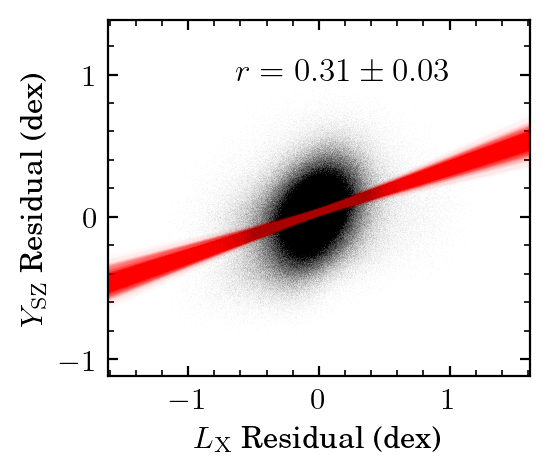

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Set style for the plots
plt.style.use('./nice.mplstyle')

# Define axis labels and relation pairs
axis_labels = [
    ("$L_\\mathrm{X}$ Residual (dex)", "$Y_\\mathrm{SZ}$ Residual (dex)"),
]
relation_pairs = [('YSZ-T', 'LX-T')]

# Generate plots
for (rely, relx), (xlabel, ylabel) in zip(relation_pairs, axis_labels):
    # Load data for y and x relations
    df_scat_y = pd.read_csv(f'/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/scatter_{rely}_added_scatter.csv')
    df_scat_x = pd.read_csv(f'/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/scatter_{relx}_added_scatter.csv')

    x = df_scat_x['Scatter'].values
    y = df_scat_y['Scatter'].values

    # Create plot
    plt.figure(figsize=(3, 2.5), dpi=200)
    sns.scatterplot(x=x, y=y, alpha=0.01, color='black', s=0.1, edgecolor=None)  # High transparency scatter
    
    # Calculate Pearson correlation coefficient
    r_ls = []
    x_min, x_max = plt.xlim()  # Get current x-axis limits
    plt.xlim(x_min, x_max)     # fix it
    for lc in range(1728):
        df_scat_x_lc = df_scat_x[df_scat_x['Lightcone'] == lc]
        df_scat_y_lc = df_scat_y[df_scat_y['Lightcone'] == lc]
        
        x_lc = df_scat_x_lc['Scatter'].values
        y_lc = df_scat_y_lc['Scatter'].values 

        # Skip lightcones with insufficient data
        if len(x_lc) < 2 or len(y_lc) < 2:
            continue
        
        r, _ = pearsonr(x_lc, y_lc)  # Calculate the Pearson coefficient
        r_ls.append(r)              # Get a list of r

        # Extend the regression line beyond the data
        line_x = np.linspace(x_min, x_max, 100)
        line_y = r * (line_x - np.mean(x_lc)) + np.mean(y_lc)
        sns.lineplot(x=line_x, y=line_y, color='red', alpha=0.01)

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Legend
    r_ls = np.array(r_ls)       # note the median and standard deviation of r_pearson
    plt.legend([f"$r={np.median(r_ls):.2f} \pm {np.std(r_ls):.2f}$"], loc="upper left")  

    # Show plot
    plt.tight_layout()

    # plt.savefig(f'./to_paper/scatter_corr_{rely}_{relx}_added_scatter.png')
    plt.show()
